In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

sc = spark.sparkContext

# PageRank #

This assignment will allow to get confident with the simplest distributed implementations of the PageRank algorithm.

As we will often print probability values, we will modify the default setting of numpy so that `float` entries in arrays are printed showing only a few decimal digits.

In [90]:
import numpy as np
np.set_printoptions(precision=3)
np.array([.12333122, .13432221, .64442143])

array([0.123, 0.134, 0.644])

Let's start considering a hypothetical (very small) portion of the Web described by a fairly simple graph, made up by seven nodes. We will univocally identify each node through an integer number (starting from zero), but for sake of visualization we also want to draw labels on each node. This is why we will start from the following `labels` list, generating automatically the corresponding integer values for nodes. In order to easily convert node numbers to labels we can build a dictionary.

In [91]:
labels = ['A', 'B', 'C', 'D',  'E', 'F', 'G']

pages = range(len(labels))

# this dictionary assiciates number in pages to labels
page_labels = {p: l for p, l in zip(pages, labels)}
page_labels

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G'}

Connections between pages will be described by a list of pairs, whose elements respectively identify the starting and the ending page.

In [0]:
links = [(1, 0), (3, 0),
         (0, 1), (5, 2),
         (6, 2), (6, 5),
         (5, 6), (2, 6),
         (0, 6), (5, 4), (4, 3)]

We will show graphs using `networkx`, a package implementing a class whose instances are oriented graphs to which nodes and edges can be easily added using the data structures we have created.

In [0]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()

for p in pages:
    g.add_node(p)

for (a, b) in links:
    g.add_edge(pages[a], pages[b])

The visualization of a graph is triggered by the invocation of `nx.draw`, and it highlights directed arcs (using a thicker part of an edge to show their direction), node labels and different coloring of nodes. We will use the latter feature later on.

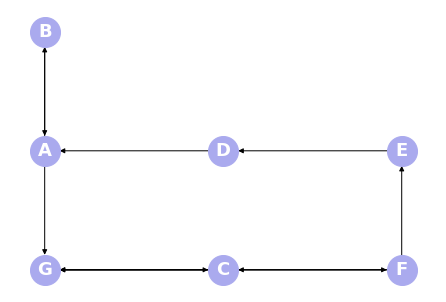

In [96]:
opts = {'node_size': 900, 
        'font_color': 'w',
        'font_size': 18,
        'font_weight': 'bold'}

pos = {0: (0, 1), 1: (0, 2), 2: (1, 0),
       3: (1, 1), 4: (2, 1), 5: (2, 0), 6: (0, 0)}

nx.draw(g, with_labels=True, labels=page_labels,
        pos=pos, node_color='#AAAAEE', **opts)
plt.show()

Building the transition matrix at the basis of PageRank it is necessary to compute the adjacency lists for each node: we can organize them into a dictionary assigning each node to its adjaceny list.

In [97]:
adjacency = {}
for u in range(len(pages)):
    adjacency[u] = []
    
for (a, b) in links:
    adjacency[a].append(b)

print(adjacency)

{0: [1, 6], 1: [0], 2: [6], 3: [0], 4: [3], 5: [2, 6, 4], 6: [2, 5]}


Starting from adjacency lists it is relatively easy to build the transition matrix, whose generic element in position \\((i, j)\\) is \\(0\\) if starting from \\(j\\)-th node it is not possible to directly reach \\(i\\)-th node, and the inverse of outer degree of \\(j\\)-th node otherwise. We will exploit the fact that this matrix is typically sparse, storing it as a list of triples \\( (i, j, m\_{ij} ) \\) but considering only triples such that \\( m_{ij} \neq 0 \\).

In [98]:
connection_matrix = []
for a in adjacency:
    for b in adjacency[a]:
        # this builds the transition matrix (beware of indices!)
        connection_matrix.append((b, a, 1./len(adjacency[a])))
connection_matrix

[(1, 0, 0.5),
 (6, 0, 0.5),
 (0, 1, 1.0),
 (6, 2, 1.0),
 (0, 3, 1.0),
 (3, 4, 1.0),
 (2, 5, 0.3333333333333333),
 (6, 5, 0.3333333333333333),
 (4, 5, 0.3333333333333333),
 (2, 6, 0.5),
 (5, 6, 0.5)]

We can now create a RDD containing the sparse representation of the transition matrix: as we will use it extensively, it is better to cache this RDD.

**Remark.** In usual conditions we would read the matrix representation from a distributed file system.

In [0]:
links_RDD = sc.parallelize(connection_matrix).cache()

We are almost ready to compute the simplest PageRank index: `n` will denote the number of analysed pages, and the two arrays `page_rank` and `old_page_rank` will store the PageRank values obtained in two successive iterations. The first will be initialized so as to describe the uniform distribution over pages in the Web portion we are considering, while the second one will be initialized in order to ensure that at least one iteration of the PageRank algorithm is executed.

In [0]:
n = len(pages)
page_rank = np.ones(n)/n
old_page_rank = np.ones(n)

In order to correctly stop the algorithm we need a function measuring the distance between two successive PageRank vectors: let's resort to the Euclidean distance, here implemented through the following `l2distance` function.

In [0]:
def l2distance(v, q):
    '''Computes the Euclidean distance between two vectors.
    
    Args
    
    v: list or tuple
    q: list or tuple
    
    Returns
    
    d: Euclidean distance between v and q
    
    Throws exception of v and q do not have the same length.
    '''
    
    if len(v) != len(q):
        raise ValueError('Cannot compute the distance'
                         ' of two vectors of different size')
    
    return sum([(q_el - v_el)**2 for v_el, q_el in zip(v, q)])

We can now implement the PageRank computation algorithm, based on the iterated product between the transition matrix and the `page_rank` vector. The iteration will proceed until the distance between two successive PageRank vector values will go below a threshold value stored in `tolerance`, and in any case after `max_iterations` have been exectued.

In [102]:
tolerance = 10e-7
max_iterations = 1000

iteration = 0
while l2distance(old_page_rank, page_rank) >= tolerance and \
      iteration < max_iterations:
    old_page_rank = page_rank
    
    page_rank_values = (links_RDD
                        .map(lambda t: (t[0], t[2]*page_rank[t[1]]))
                        .reduceByKey(lambda a, b: a+b)
                        .sortByKey()
                        .collect()
                       )
    
    page_rank = np.array([c for (i, c) in page_rank_values])
    
    print(page_rank)

    iteration += 1

[0.286 0.071 0.119 0.143 0.048 0.071 0.262]
[0.214 0.143 0.155 0.048 0.024 0.131 0.286]
[0.19  0.107 0.187 0.024 0.044 0.143 0.306]
[0.131 0.095 0.2   0.044 0.048 0.153 0.329]
[0.139 0.065 0.216 0.048 0.051 0.165 0.317]
[0.113 0.069 0.213 0.051 0.055 0.158 0.34 ]
[0.12  0.057 0.223 0.055 0.053 0.17  0.323]
[0.111 0.06  0.218 0.053 0.057 0.161 0.34 ]
[0.113 0.056 0.224 0.057 0.054 0.17  0.327]
[0.112 0.056 0.22  0.054 0.057 0.164 0.337]
[0.11  0.056 0.223 0.057 0.055 0.168 0.331]
[0.113 0.055 0.222 0.055 0.056 0.166 0.334]
[0.11  0.056 0.222 0.056 0.055 0.167 0.333]
[0.113 0.055 0.222 0.055 0.056 0.167 0.333]
[0.11  0.056 0.222 0.056 0.056 0.166 0.334]
[0.112 0.055 0.223 0.056 0.055 0.167 0.332]
[0.111 0.056 0.222 0.055 0.056 0.166 0.334]
[0.111 0.055 0.222 0.056 0.055 0.167 0.333]
[0.111 0.056 0.222 0.055 0.056 0.166 0.334]
[0.111 0.055 0.222 0.056 0.055 0.167 0.333]
[0.111 0.056 0.222 0.055 0.056 0.166 0.334]


How many iterations have been executed? Did the system converge or did the maximum iteration number was reached?

In [103]:
iteration

21

A better way to analyze the obtained result is through graphical visualization, showing the graph describing our portion of the Web and using for each node a red shade linked to the corresponding PageRank value.

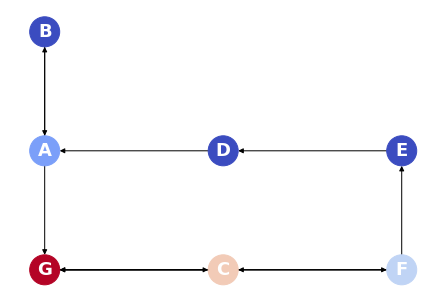

In [104]:
nx.draw(g, with_labels=True, labels=page_labels, pos=pos,
        node_color=page_rank, cmap=plt.cm.coolwarm, **opts)
plt.show()

We want now to perform some exploratory analysis of simple variants of the PageRank algorithm. In order to avoid writing the same code several times, let's set up the following functions:

* `get_graph`, accepting as inputs the lists of nodes and of connections and returning the corresponding graph;
* `get_connection_matrix`, accepting as inputs the lists of connections and returning the transition matrix;
* `get_page_rank`, accepting as input the lists of nodes and connections and returning the corresponding PageRank vector; this function will also accept the optional arguments `verbose` (with default value `False`, allowing to print the PageRank vector at each iteration), `tolerance` and `max_iterations` (respectively with default values `10e-7` and `100` and whose behaviour is that of the previously introduced variables having the same names).

In [0]:
def get_graph(pages, links):
    g = nx.DiGraph()

    for p in pages:
        g.add_node(p)

    for (a, b) in links:
        g.add_edge(pages[a], pages[b])

    return g

def get_connection_matrix(pages, links):
    incidency = {}
    for u in range(len(pages)):
        incidency[u] = []
    
    for (a, b) in links:
        incidency[a].append(b)
    
    connection_matrix = []
    for a in incidency:
       for b in incidency[a]:
            connection_matrix.append((b, a, 1./len(incidency[a])))
            
    return connection_matrix

def get_page_rank(pages, links,
                  verbose=False, tolerance=10e-7, max_iterations=100):
    connection_matrix = get_connection_matrix(pages, links)
    links_RDD = sc.parallelize(connection_matrix).cache()

    n = len(pages)
    page_rank = np.ones(n)/n
    old_page_rank = np.ones(n)
    
    iteration = 0
    while l2distance(old_page_rank, page_rank) >= tolerance and \
          iteration < max_iterations:
        old_page_rank = page_rank
        page_rank_values = (links_RDD
                            .map(lambda t: (t[0], t[2]*page_rank[t[1]]))
                            .reduceByKey(lambda a, b: a+b)
                            .sortByKey()
                            .collect()
                           )
        page_rank = np.array([c for (i, c) in page_rank_values])
            
        if verbose:
            nice_print(page_rank)

        iteration += 1
        
    print('{} iterations'.format(iteration))
    
    return page_rank

Let's check these functions on the already available graph and test that they return the same PageRank values.

In [106]:
page_rank = get_page_rank(pages, links)

21 iterations


In [107]:
page_rank

array([0.111, 0.056, 0.222, 0.055, 0.056, 0.166, 0.334])

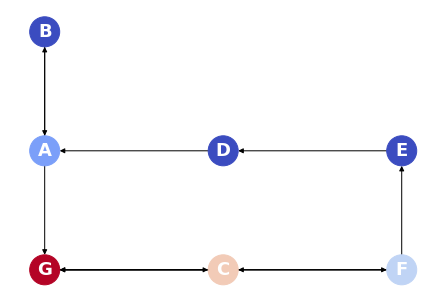

In [108]:
g = get_graph(pages, links)
nx.draw(g, with_labels=True, labels=page_labels, pos=pos,
        node_color=page_rank, cmap=plt.cm.coolwarm, **opts)

Let's consider now the following graph, having node B as a dead end.

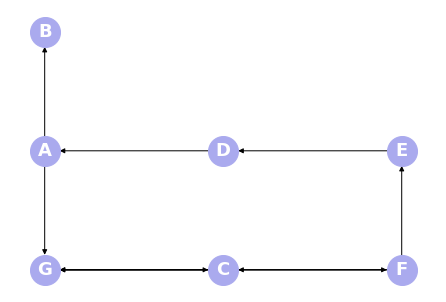

In [109]:
links = [
         (3, 0), (0, 1),
         (5, 2), (6, 2),
         (6, 5), (5, 6),
         (2, 6), (0, 6),
         (5, 4), (4, 3),
        ]

g = get_graph(pages, links)
nx.draw(g, with_labels=True, labels=page_labels,
        pos=pos, node_color='#AAAAEE', **opts)

What happens if we compute its PageRank value?

In [110]:
page_rank = get_page_rank(pages, links)

73 iterations


Why is this result odd? The following cell should give you a hint.

In [111]:
page_rank

array([0.004, 0.002, 0.014, 0.004, 0.004, 0.01 , 0.02 ])

In [112]:
sum(page_rank)

0.05721862657052279

Despite the unpleasant results we obtained, show the graph together with node coloring according to the obtained PageRank values

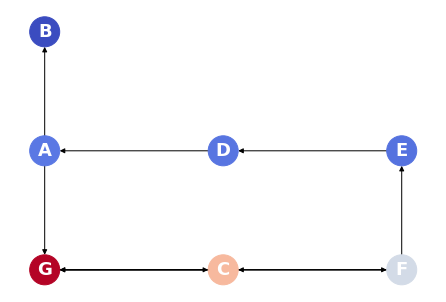

In [113]:
nx.draw(g, with_labels=True, labels=page_labels,
        pos=pos, node_color=page_rank, cmap=plt.cm.coolwarm, **opts)

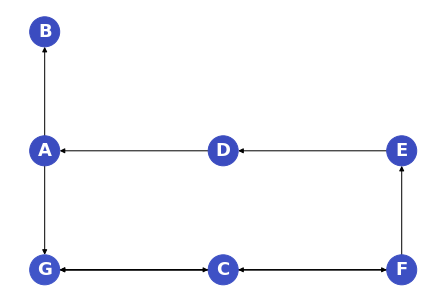

In [114]:
nx.draw(g, with_labels=True, labels=page_labels,
        pos=pos, node_color=page_rank, cmap=plt.cm.coolwarm,
        **opts, vmin=0, vmax=1)

Consider now another graph, containing the spider trap identified by nodes B, H, and I.

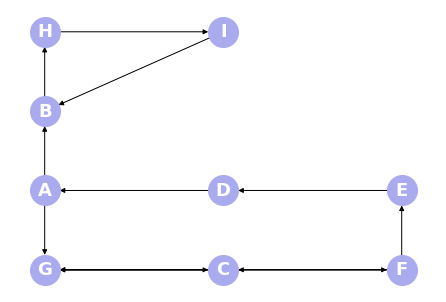

In [115]:
labels = ['A',  'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

pages = range(len(labels))

page_labels = {page: label for page, label in zip(pages, labels)}

links = [
         (3, 0), (0, 1), (5, 2),
         (6, 2), (6, 5), (5, 6),
         (2, 6), (0, 6), (5, 4), (4, 3),
         (1, 7), (7, 8), (8, 1)
        ]

g = get_graph(pages, links)
pos_trap = {0: (0, 1), 1: (0, 2), 2: (1, 0), 3: (1, 1),
            4: (2, 1), 5: (2, 0), 6: (0, 0), 7: (0, 3), 8: (1, 3)}
#plt.cla()
nx.draw(g, with_labels=True, labels=page_labels,
        pos=pos_trap, node_color='#AAAAEE', **opts)

Compute and print the PageRank values for this graph.

In [116]:
page_rank = get_page_rank(pages, links)

100 iterations


As in previsous cases, show the graph coloring its nodes according to their PageRank values.

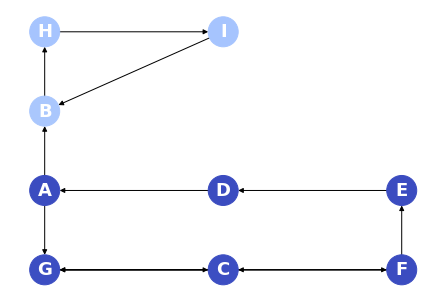

In [117]:
nx.draw(g, with_labels=True, labels=page_labels,
        pos=pos_trap, node_color=page_rank, cmap=plt.cm.coolwarm,
        **opts, vmin=0, vmax=1)

In [118]:
page_rank

array([0.001, 0.336, 0.004, 0.001, 0.001, 0.003, 0.006, 0.324, 0.324])

Modify the `get_page_rank` function in order to implement the taxation-based variant. Note that the function signature has been modified in order to accept an optional argument `beta` playing the role of parameter \\(\beta\\) in the variant.

In [0]:
def get_page_rank(pages, links, beta=0.8,
                  max_iterations=400, tolerance=1.e-5, verbose=False):

    connection_matrix = get_connection_matrix(pages, links)
    links_RDD = sc.parallelize(connection_matrix).cache()

    n = len(pages)
    page_rank = np.ones(n)/n
    old_page_rank = np.ones(n)
    
    iteration = 0
    while l2distance(old_page_rank, page_rank) >= tolerance and \
          iteration < max_iterations:
        old_page_rank = page_rank
        page_rank_values = (links_RDD
                            .map(lambda t: (t[0], t[2]*page_rank[t[1]]))
                            .reduceByKey(lambda a, b: a+b)
                            .sortByKey()
                            .collect()
                           )
        page_rank = np.array([beta*c + (1-beta)/n
                              for (i, c) in page_rank_values])
            
        if verbose:
            print(page_rank)

        iteration += 1
        
    print('{} iterations'.format(iteration))
    
    return page_rank

Apply the taxation method-based variant to the following graph exhibiting a dead end, and check that the results are different from those previously obtained.

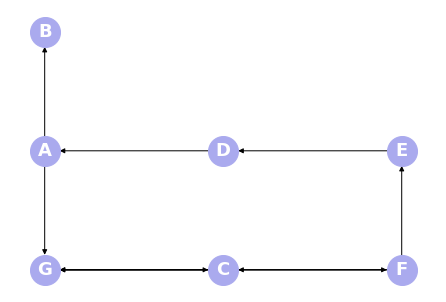

In [120]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

pages = range(len(labels))

page_labels = {page: label for page, label in zip(pages, labels)}

links = [
         (3, 0), (0, 1), (5, 2), (6, 2),
         (6, 5), (5, 6), (2, 6), (0, 6),
         (5, 4), (4, 3),
        ]

g = get_graph(pages, links)
nx.draw(g, with_labels=True, labels=page_labels,
        node_color='#AAAAEE', pos=pos, **opts)

8 iterations


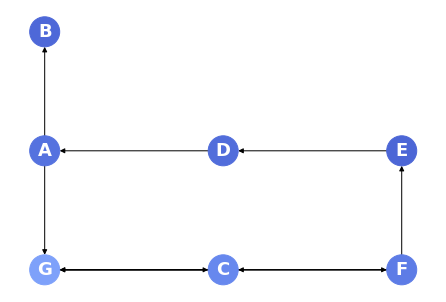

In [121]:
page_rank = get_page_rank(pages, links)
nx.draw(g, with_labels=True, labels=page_labels,
        pos=pos, node_color=page_rank, cmap=plt.cm.coolwarm,
        **opts, vmin=0, vmax=1)

In [122]:
page_rank

array([0.089, 0.065, 0.143, 0.076, 0.059, 0.113, 0.21 ])

Do the same with the following graph containing a spider trap.

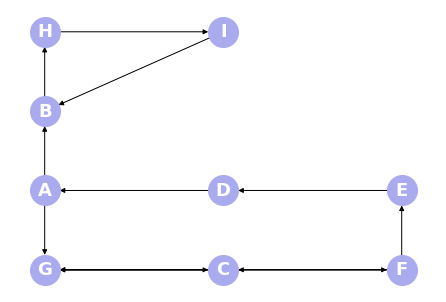

In [123]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

pages = range(len(labels))

page_labels = {page: label for page, label in zip(pages, labels)}

links = [
         (3, 0), (0, 1), (5, 2),
         (6, 2), (6, 5), (5, 6),
         (2, 6), (0, 6), (5, 4), (4, 3),
         (1, 7), (7, 8), (8, 1)
        ]

g = get_graph(pages, links)
nx.draw(g, with_labels=True, labels=page_labels,
        pos=pos_trap, node_color='#AAAAEE', **opts)

9 iterations


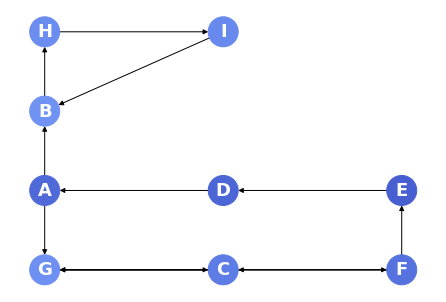

In [124]:
page_rank = get_page_rank(pages, links)
nx.draw(g, with_labels=True, labels=page_labels,
        pos=pos_trap, node_color=page_rank, cmap=plt.cm.coolwarm,
        **opts, vmin=0, vmax=1)

In [125]:
page_rank

array([0.07 , 0.165, 0.111, 0.059, 0.046, 0.088, 0.163, 0.154, 0.146])

Consider the following **topic-sensitive** version of PageRank: suppose that you know that a subsed \\(E\\) of the pages you are considering speaks about a specific argument, say Java. You can bias the PageRank algorithm to giving higher importance to such pages modifying how the taxation method works: when taxation takes place, instead of teleporting the random surfers to a generic page, teleport him/her to one of the pages in \\(E\\) chosen uniformly at random.

In your previous assignment you saved to file the equivalent of the transition matrix for a set of books, where a (bidirectional) link between two books was in place if and only if they shared at least a coauthor. You also saved in another file the association of each book to the fact that it is related to the Java programming language.

Implement the topic-senstivie variant of PageRank and apply it to your books dataset.